# Calculate CESM Indeces

This file just calculates all the indeces for all months for all cesmFullForcingFiles.

Could be generalised if desired.

In [ ]:
#import my functions
import helpers.fileHandler as fh
import utils._modelDefinitions as _model
import utils.sstIndex as sst
import utils.pslIndex as psl


In [ ]:
import xarray
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Data for climatology

In [ ]:
sstClimatDs=fh.loadModelData('CESM-LME', 'SST', '0850cntl.001')
pslClimatDs=fh.loadModelData('CESM-LME', 'PSL', '0850cntl.001')

sstClimat=sst.calculateClimatology(sstClimatDs, 850, 2005)
pslClimat=psl.calculateClimatology(pslClimatDs, 850, 2005)

#loading both those things
for keys in sstClimat:
    sstClimat[keys].load()
    
pslClimat.load()

In [ ]:
sstClimatDs.close()
pslClimatDs.close()

For each experiment in Full Forcings, calculate all the indeces

In [ ]:
timePIndeces=dict()

for experiment in _model.cesmFullForcings:
    print(experiment)
    sstDs = fh.loadModelData('CESM-LME', 'SST', experiment)
    pslDs = fh.loadModelData('CESM-LME', 'PSL', experiment)
    pslIndex = psl.calculateSamIndex(pslDs, pslClimat)
    sstIndex = sst.calculateIndex(sstDs, sstClimat) #(reducing the model set at this step could save time?)
    indeces = xarray.merge([pslIndex, sstIndex])
    indeces.assign_attrs(climatology='calculated based on 850-2005 climatology from the control run')
    #indeces.to_netcdf('results/cesmMonthlyIndeces/' + experiment + '.nc')

    
    timePIndeces[experiment] = averageForTimePeriod(indeces)

In [ ]:
# RCP8.5 extensions are a special case


for experiment in ['002','003', '008', '009']:
    
    pre2005Ds = xarray.load_dataset('results/cesmMonthlyIndeces/' + experiment + '.nc')
                                    
    print('LME.'+experiment)
    
    sstDs = fh.loadModelData('CESM-LME', 'SST', 'LME\.'+experiment)
    
    extensionIndex=sst.calculateIndex(sstDs, sstClimat)
    
    sstIndex = xarray.concat(
        (pre2005Ds[[keys for keys in extensionIndex.data_vars]], extensionIndex),
        'time'
    )
        
    
    pslDs = fh.loadModelData('CESM-LME', 'PSL', 'LME.'+experiment)
        
    extensionIndex=psl.calculateSamIndex(pslDs, pslClimat)
    
    pslIndex=xarray.concat(
        (pre2005Ds[[keys for keys in extensionIndex.data_vars]], extensionIndex),
        'time'
    )
    
    indeces = xarray.merge([pslIndex, sstIndex])
    indeces.assign_attrs(climatology='calculated based on 850-1850 climatology')
    #indeces.to_netcdf('results/cesmMonthlyIndeces/LME.' + experiment + '.nc')

    
    timePIndeces[experiment] = averageForTimePeriod(indeces)

In [ ]:
#loading both those things
for keys in sstClimat:
    sstClimat[keys].close()
    
pslClimat.close()

# Calculate CESM Indeces

This grabs the monthly CESM indeces, and calculates the averages for the time periods of interest (aka the warm season), as set in the _indexDefitionions file

You need to run 'calculateCesmMonthlyIndeces.ipnyb' first

Theres a few examples of output at the bottom to sanity check this is meaningful

In [3]:
#experimentSet = ['LME.002']
experimentSet = _model.cesmAll

The indeces for each month have already been calculated. So loading up the saves versions, and putting them into a dict of pandas arrays.

To make this all easier to deal with, convert the result into an xarray and add some extra relevant information as attributes.

This allows for filtering by index, year or experiment 

In [6]:
# so i've just written the results into a dict of pandas array. This is kinda funky because I can't slice one index across multiple models
# instead, put the whole thing into an xarray with a dimension for the experiment
results=xarray.concat(
    [
        xarray.DataArray(timePIndeces[experiment], 
                         dims=['year','index'], 
                         coords={
                             'year':timePIndeces[experiment].index,
                             'index':timePIndeces[experiment].columns,
                             'experiment': experiment})
    for experiment in experimentSet 
    ],
    dim='experiment'
)

results.assign_attrs(indeces.attrs)
results.assign_attrs(_index.monthsOfInterest)



<xarray.DataArray (experiment: 17, year: 1250, index: 10)>
array([[[ 0.56489564,  0.64176114,  0.64071857, ...,  0.53931696,
         -0.40616436, -1.05913781],
        [-0.52189864, -0.31021488,  0.74078515, ...,  0.8035476 ,
         -1.09993313,  0.27259859],
        [-0.82387401, -0.76070974, -0.11475646, ...,  0.07605467,
          0.42804666,  0.24537125],
        ...,
        [ 6.21917299,  4.13535914,  3.66837151, ...,  0.21418979,
         -1.96766615,  2.28590201],
        [ 2.16968197,  1.95987606,  3.99700446, ...,  0.71226082,
          1.0873277 ,  1.95488545],
        [ 2.23494946,  2.15853915,  2.65672527, ..., -0.24489924,
          1.56525319,  2.91891506]],

       [[ 1.91364928,  1.72275008,  0.78683539, ...,  0.54953177,
         -1.32941939,  0.00719795],
        [ 2.26464121,  1.7958792 ,  0.8312409 , ...,  0.44394377,
         -1.63000718, -0.81249646],
        [-0.54628116,  0.03264722,  0.35596996, ...,  0.20465232,
         -0.07104712, -0.02617606],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[ 1.28820205,  1.38659408,  0.46279439, ...,  0.24001302,
         -0.67776912,  1.07090288],
        [-0.6064628 , -0.41875404,  0.69651249, ...,  0.65499138,
         -0.84109509,  2.10737237],
        [-0.77963882, -0.60278521, -0.17938118, ..., -0.02283294,
          0.45650675,  1.05586198],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * year        (year) int64 850 851 852 853 854 ... 2095 2096 2097 2098 2099
  * index       (index) object 'nino34NoDetrend' 'nino4NoDetrend' ... 'sam'
  * experiment  (experiment) <U7 'LME.002' 'LME.003' 'LME.008' ... '012' '013'
Attributes:
    nino34NoDetrend:  [7, 15]
    nino4NoDetrend:   [7, 15]
    westIONoDetrend:  [7, 12]
    eastIONoDetrend:  [7, 12]
    dmi:              [7, 15]
    nino34:           [7, 15]
    nino4:            [7, 15]
    westIO:           [7, 12]
    eastIO:           [7, 12]
    sam:              [10, 15]

Save the result for use later

In [7]:
results.to_netcdf('results/cesmTradIndeces.nc')

# Some sanity checks to see if it looks ok:


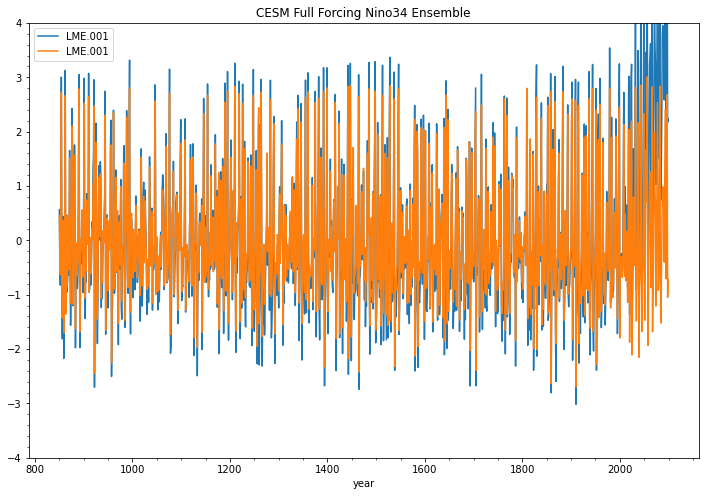

In [8]:
# plotSomething
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

#results.sel(experiment='001', index='nino34').plot(label='001')
results.sel(experiment='LME.002', index='nino34NoDetrend').plot(label='LME.001')
results.sel(experiment='LME.002', index='nino34').plot(label='LME.001')

#Tidy up a bit
plt.title("CESM Full Forcing Nino34 Ensemble")
plt.ylim(-4,4)
plt.minorticks_on()
plt.legend()

In [13]:
# A multi-experiment mean?

mean = results.sel(index='sam').mean(dim='experiment')
std = results.sel(index='sam').std(dim='experiment')

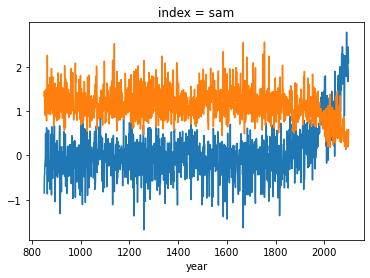

In [14]:
plt.figure()
mean.plot()
std.plot()

In [15]:
# why limit yourself to one index?

mean = results.sel(experiment=_model.cesmFullForcings).mean(dim='experiment')
std = results.sel(experiment=_model.cesmFullForcings).std(dim='experiment')

In [16]:
std

<xarray.DataArray (year: 1250, index: 10)>
array([[0.81332838, 0.58484674, 0.29470177, ..., 0.24562248, 0.77921066,
        1.30768105],
       [1.29710742, 0.72666774, 0.39029816, ..., 0.31659111, 0.70331694,
        1.59483385],
       [1.30414683, 1.02186656, 0.30915089, ..., 0.20700577, 0.87949556,
        1.39123045],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * year     (year) int64 850 851 852 853 854 855 ... 2095 2096 2097 2098 2099
  * index    (index) object 'nino34NoDetrend' 'nino4NoDetrend' ... 'sam'